# Outlier statistics
- Determining if a sample or timepoint is a statistical outlier often a two-step process:
    1. Estimate a distribution assumed to be normal operating conditions.
    2. Check if new samples are significant outliers from this distribution.
- (Multivariate) [Statistical Process Control](https://en.wikipedia.org/wiki/Statistical_process_control), part of [$6\sigma$](https://en.wikipedia.org/wiki/Six_Sigma) process improvement, has a wide range of methods for this.

## Statistical Process Control - SPC
- The simplest form handles a single variable.
- A normal distribution is assumed, but some deviation is tolerated.
- It also assumes a constant/stationary process and no shifts/trends in distributions.
- Any value outside +/- 3 standard deviations (SD) of the mean is assumed to be an outlier.

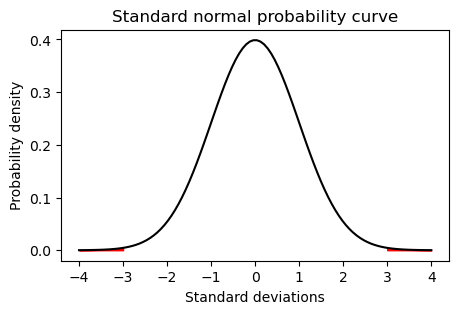

In [1]:
# Plot the normal probability curve from -4 to 4 with mean 0 and standard deviation 1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, color='black')
plt.xlabel('Standard deviations')
plt.ylabel('Probability density')
plt.title('Standard normal probability curve')
# Shade the area under the curve to the left of -3 and right of 3
px = np.linspace(-4, -3, 100)
py = stats.norm.pdf(px, 0, 1)
plt.fill_between(px, py, color='red')
px = np.linspace(3, 4, 100)
py = stats.norm.pdf(px, 0, 1)
plt.fill_between(px, py, color='red')
plt.show()

In [2]:
# Calculate the probability of being outside +/- 3 SD in a normal distribution, i.e. P(|X| > 3).
# Format the result as a percentage rounded to two decimal places.
import scipy.stats as stats
prob = stats.norm.cdf(-3)*2
print('Probability of being outside outside +/- 3 SD in a normal distribution: {:.2%}'.format(prob))
# Rewrite this as the proportion of values, i.e., 1 in n, that are outside +/- 3 SD in a normal distribution.
print('Proportion of values that are outside +/- 3 SD in a normal distribution: 1 in {:.0f}'.format(1/prob))

Probability of being outside outside +/- 3 SD in a normal distribution: 0.27%
Proportion of values that are outside +/- 3 SD in a normal distribution: 1 in 370


### Control charts
- A common way of assessing outliers is to plot the series together with lower and upper boundaries.

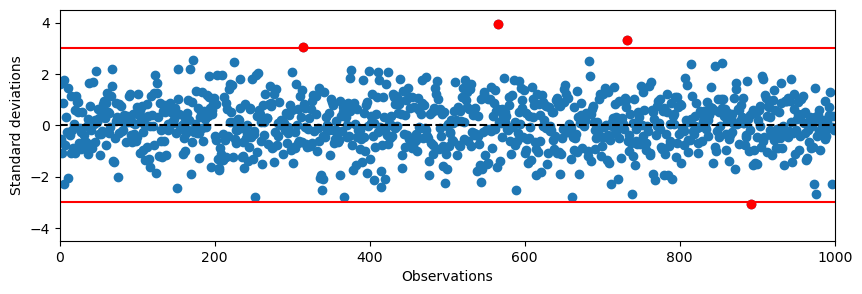

In [3]:
# Plot random normal data with 1000 values with a seed of 1
import numpy as np
np.random.seed(1)
data = np.random.normal(0, 1, 1000)
plt.figure(figsize=(10,3))
plt.plot(data, 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, 1000)
plt.axhline(0, color='black', linestyle='--')
plt.axhline(3, color='red')
plt.axhline(-3, color='red')
plt.ylabel('Standard deviations')
plt.xlabel('Observations')
# Plot all samples that are outside +/- 3 SD in a normal distribution in red
outliers = data[np.abs(data) > 3]
plt.plot(np.where(np.abs(data) > 3)[0], outliers, 'o', color='red')
plt.show()

### Histograms
- Histograms show you a cummulative view over a set of observations.
- If the observed distribution is very different from a bell curve (normal distribution), the +/-3 SD will not have the expected coverage.
    - Associated P-values will be wrong.

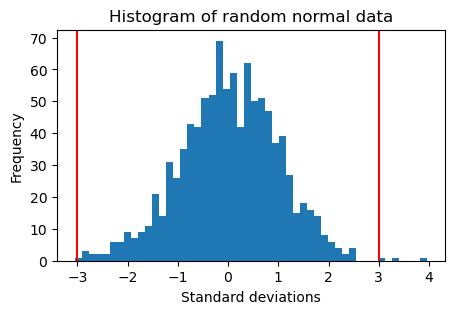

In [4]:
# Plot the same data as a histogram
plt.figure(figsize=(5,3))
plt.hist(data, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Standard deviations')
plt.title('Histogram of random normal data')
plt.axvline(3, color='red')
plt.axvline(-3, color='red')
plt.show()

In [5]:
# Calculate the probability of observing a value more extreme 
# than the maximum absolute value in the data set at random
stats.norm.sf(np.max(np.abs(data)))*2

7.53895218829654e-05

### Quantile plots
- A quantile plot plots expected quantiles of a distributon against observed quantiles from data.
- The basic distribution is the normal probability distribution.

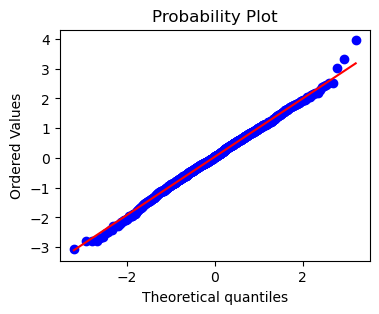

In [6]:
# A quantile plot can also help to identify outliers and deviations from normality
plt.figure(figsize=(4,3))
stats.probplot(data, dist='norm', plot=plt)
plt.show()

### Robust statistics
- Instead of mean and standard deviation, one can use more robust calculations.
- _Trimmed mean_ means first removing a proportion, e.g., 5\% of the most extreme observations before calculating the mean.
    - Robust against outliers.
- [_Median absolute deviation_](https://en.wikipedia.org/wiki/Median_absolute_deviation) is the median of the absolute deviations from the median value.
    - Robust against non-normality.
  
$$MAD = median(|X_i - \tilde{X}|), ~~~ \tilde{X} = median(X)$$
  
- Relation to standard deviation: $\hat{\sigma} = k \cdot MAD$.
- For normal data $k \approx 1.4826$, see Wikipedia.

In [7]:
# Trimmed mean
m1 = np.mean(data)
m2 = stats.trim_mean(data, 0.05)
print('Mean: {:.3f}'.format(m1))
print('Trimmed mean: {:.3f}'.format(m2))

Mean: 0.039
Trimmed mean: 0.046


In [8]:
# Median absolute deviation
s1 = np.std(data)
s2 = stats.median_abs_deviation(data)
print('Standard deviation: {:.3f}'.format(s1))
print('Median absolute deviation: {:.3f}'.format(s2))

Standard deviation: 0.981
Median absolute deviation: 0.647


In [9]:
# SD vs MAD
print('Adjusted MAD: {:.3f}'.format(s2 * 1.4826))

Adjusted MAD: 0.959


## Heuristics
- As seen above, to be flagged in the base case will happen by accident 1 in 370 cases.
- The probability quickly shrinks if additional requirements are added, e.g., 3 cases in a row outside +/- 3 std.
    - With multiple consecutive outliers, one can also use fewer standard deviations.
- If data are assumed to be iid (independent and identically distributed), another heuristic can be to check concecutive samples are too similar (and possibly non-centred).
    - This can indicate a bias in the series, e.g., caused by a manufacturing step caught in an error condition.
- A shift in mean value can also be indicative of errors or unwanted changes; checkable using rolling means or similar with an appropriate window size.

In [10]:
# Assuming independent samples, calculate the probability of observing
# three values in a row above 2 SD in a normal distribution.
prob3 = (1-stats.norm.cdf(2))**3
print('Probability: {:.4%}'.format(prob3))
print('Proportion: 1 in {:.0f}'.format(1/prob3))

Probability: 0.0012%
Proportion: 1 in 84927


In [11]:
# Create a function that checks if n consecutive samples are above k SD or below k SD
def check_consecutive(data, k, n, mu, SD):
    index = []
    dataUp = (data-mu) > k*SD
    dataDown = (data-mu) < -k*SD
    for i in range(len(data)-n+1):
        if np.all(dataUp[i:i+n]) or np.all(dataDown[i:i+n]):
            index.append(i)
    return index

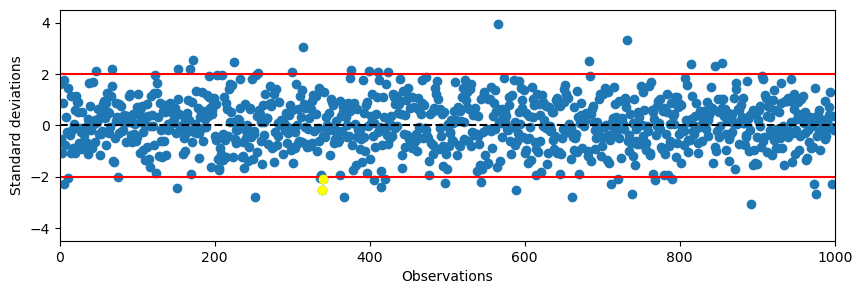

In [12]:
# Apply hueristic function and plot
k = 2
n = 2
mu = 0
SD = 1
index = check_consecutive(data, k, n, mu, SD)

plt.figure(figsize=(10,3))
plt.plot(data, 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, 1000)
plt.axhline(0, color='black', linestyle='--')
plt.axhline(k*SD, color='red')
plt.axhline(-k*SD, color='red')
plt.ylabel('Standard deviations')
plt.xlabel('Observations')
# Plot all samples that are caught by the heuristic function
for i in index:
    plt.plot(range(i,i+n), data[range(i,i+n)], 'o', color='yellow')
plt.show()

## Exercise
- Import the data called _bananas.csv_.
- Assume the first 500 samples are "in control" and calculate their _mean_ and _standard deviation_.
- Plot the whole series and indicate outliers using SPC and heuristics.

## Multivariate series
- Though each variable can be handled separately with SPC, it is often more interesting to assess the combined effect.
- Smaller deviations in single variables may be detected if these occur in relation to other variables and their variation.
- Instead of the normal distribution, we use [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) and the associated [Hotelling's $T^2$](https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution), a multivariate generalisation of the student t-distribution. $t^2$ is defined as:  
  
$$t^2 = (\bar{x}-\mu) \hat{\Sigma}_{\bar{x}}^{-1} (\bar{x}-\mu)^T$$
  
- In practice we estimate $\bar{x}$ and $\hat{\Sigma}_{\bar{x}}$ from "in control" data and look at single observations for $\mu$.
  
$$\frac{n-p}{p(n-1)}t^2 \sim F_{p,n-p}$$
  
where $n$ is the number of samples in the training data and $p$ is the number of variables.

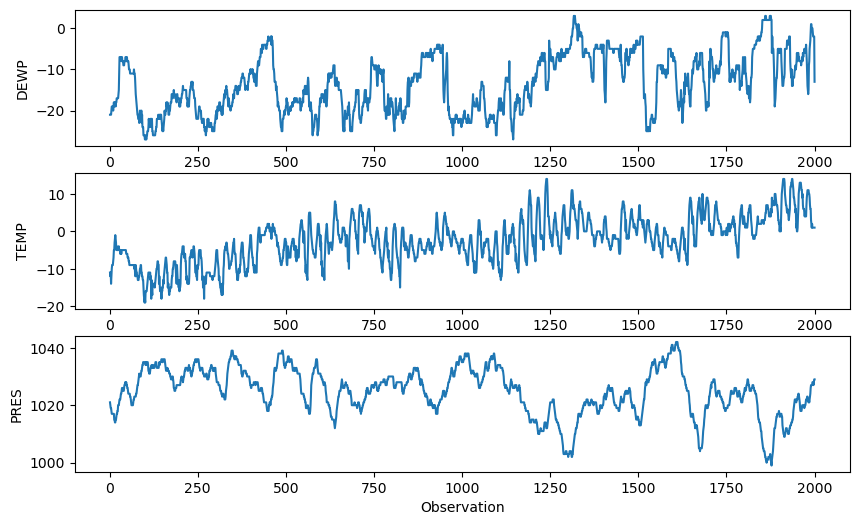

In [13]:
# Read the Beijing pollution data
import pandas as pd
pollution = pd.read_csv("../../data/pollution.csv", header=0, index_col=0)
# Extract the first 2000 samples of DEWP, TEMP and PRES
pdata = pollution[['DEWP', 'TEMP', 'PRES']].iloc[:2000]

# Plot the three variables as separate subplots above each other
plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(pdata['DEWP'], '-')
plt.ylabel('DEWP')
plt.subplot(312)
plt.plot(pdata['TEMP'], '-')
plt.ylabel('TEMP')
plt.subplot(313)
plt.plot(pdata['PRES'], '-')
plt.ylabel('PRES')
plt.xlabel('Observation')
plt.show()

We use the first three years as the "in control" region and estimate mean and covariance from it.

In [14]:
# Calculate the mean vector and covariance matrix of the three variables for the first 3 years
import numpy as np
mean = np.mean(pdata.values[:365*3,:], axis=0)
cov = np.cov(pdata.values[:365*3,:], rowvar=False)
print(mean)
print(cov)

[ -16.62009132   -5.42648402 1028.2803653 ]
[[ 33.50636014   8.27369045 -16.68247894]
 [  8.27369045  27.0510347  -12.9269373 ]
 [-16.68247894 -12.9269373   32.5255282 ]]


In [15]:
# Calculate the Hotelling's T^2 statistic for each observation given mu and cov
def Hotellings_T2(X, mean, cov, n, alpha = 0.01):
    T2 = np.sum(((X-mean) @ np.linalg.inv(cov)) * (X-mean), axis=-1)
    p = len(mean)
    F = (n-p)/(p*(n-1))*T2
    P = stats.f.sf(F, p, n-p)
    # Critical value
    c = stats.f.isf(alpha, p, n-p)*p*(n-1)/(n-p)
    return (T2, F, P, c)

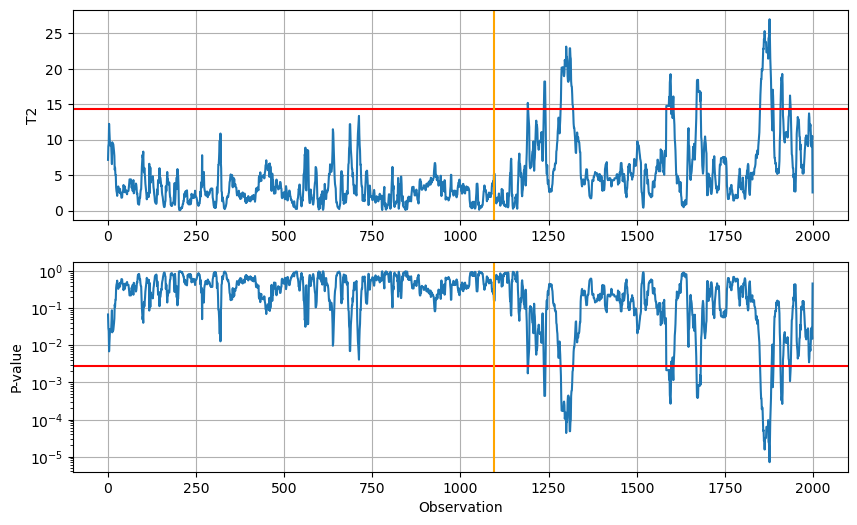

In [16]:
# Apply Hotellings_T2 and plot
alpha = 0.0027
T2, F, P, c = Hotellings_T2(pdata.values, mean, cov, 365*3, alpha)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(T2)
plt.grid()
plt.axhline(c, color="red")
plt.axvline(365*3, color="orange")
plt.ylabel("T2")
plt.subplot(212)
# Plot P on a logarithmic scale
plt.plot(P)
plt.yscale("log")
plt.grid()
plt.axhline(alpha, color="red")
plt.axvline(365*3, color="orange")
plt.ylabel("P-value")
plt.xlabel("Observation")
plt.show()

Finally, we observe which observations are marked as outlying in the original series.

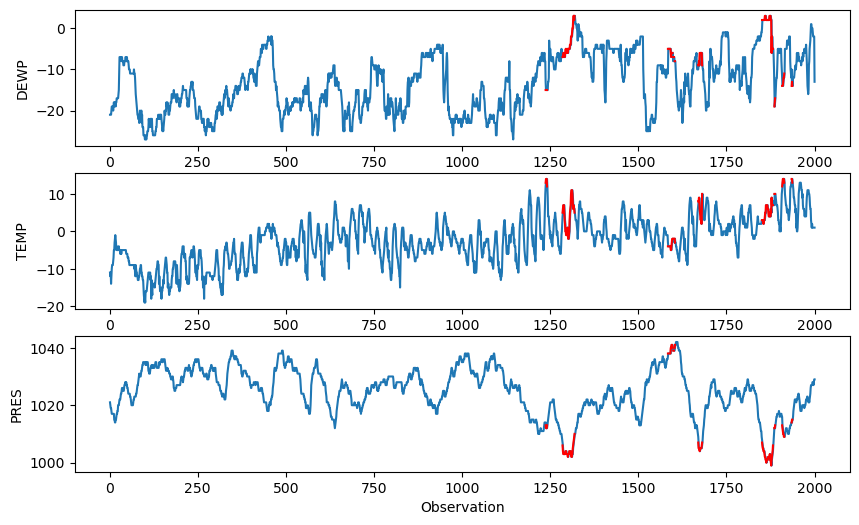

In [17]:
# Plot the three variables as separate subplots above each other, marking the outlying regions in red
x = np.arange(2000)+0.0
x[P>alpha] = np.nan

plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(pdata['DEWP'], '-')
plt.plot(x, pdata['DEWP'], '-', color='red')
plt.ylabel('DEWP')
plt.subplot(312)
plt.plot(pdata['TEMP'], '-')
plt.plot(x, pdata['TEMP'], '-', color='red')
plt.ylabel('TEMP')
plt.subplot(313)
plt.plot(pdata['PRES'], '-')
plt.plot(x, pdata['PRES'], '-', color='red')
plt.ylabel('PRES')
plt.xlabel('Observation')
plt.show()

### Robust multivariate statistics
- Also multivariate data can need robust statistics because of non-normality or outliers.
- One method for robust estimation of mean and standard deviation is called Minimum Covariance Determinant (MCD).
- MCD uses a subset of samples that minimises the determinant of the covariance matrix.
- [An iterative method that searches for the MCD](https://www.researchgate.net/publication/2298225_A_Fast_Algorithm_for_the_Minimum_Covariance_Determinant_Estimator) is implemented in scikit-learn's [MinCovDet](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html).

In [18]:
# Import Minimum Covariance Determinant estimator from scikit-learn
from sklearn.covariance import MinCovDet
# Apply the Minimum Covariance Determinant estimator to data.values[:365*3,:] and plot
some_data = np.random.multivariate_normal(mean, cov, 3)
mcd = MinCovDet(random_state=1).fit(some_data)
mcd_mean = mcd.location_
mcd_cov = mcd.covariance_

In [19]:
print(mcd_mean)
print(mcd_cov)

[-1.77587033e+01  1.15297350e-01  1.02581453e+03]
[[ 31.79452702 -15.89510593  -0.58264256]
 [-15.89510593  11.42576239   3.64555942]
 [ -0.58264256   3.64555942   3.24443596]]


### Exercise
- Repeat the calculations of mean, covariance Hotelling's $T^2$, etc. for the Beijing pollution data.
- Exchange ordinary statistics with the MCD alternative.

## Time resolution
- The (M)SPC examples have assumed a constant mean and standard deviation.
- It may also be interesting to look at det deviation from smoothed data to look for local outliers.
    - This corresponds to a high-pass filter for FFT.
- In the rich field of (M)SPC there are also other methods tailored for find shifts in trends.

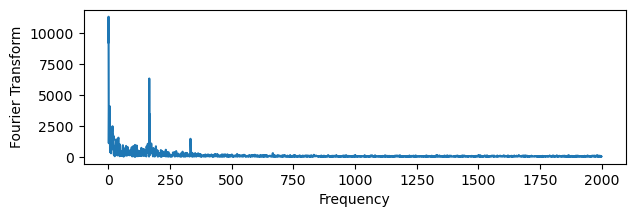

In [20]:
from scipy.fft import dct, idct
fourier_signal = dct(pdata["TEMP"].values)

# Plot the Fourier transform
plt.figure(figsize=(7,2))
plt.plot(np.abs(fourier_signal))
plt.xlabel('Frequency')
plt.ylabel('Fourier Transform')
plt.show()

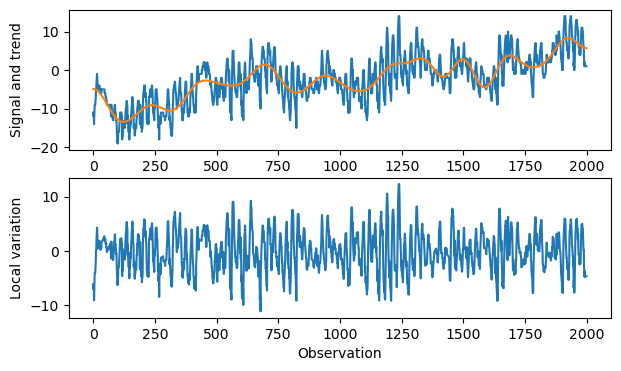

In [21]:
# Filter the Fourier transform by setting all frequencies below a threshold to zero
W = np.arange(0, 2000) # Frequency axis
filtered_fourier_signal = fourier_signal.copy()
filtered_fourier_signal[(W<30)] = 0
cut_signal = idct(filtered_fourier_signal)

# Plot the filtered signal
plt.figure(figsize=(7,4))
plt.subplot(211)
plt.plot(pdata["TEMP"].values)
plt.plot(pdata["TEMP"].values - cut_signal)
plt.ylabel('Signal and trend')
plt.subplot(212)
plt.plot(cut_signal)
plt.ylabel('Local variation')
plt.xlabel('Observation')
plt.show()

## Resources
- [Wikipedia: Statistical Process Control](https://en.wikipedia.org/wiki/Statistical_process_control)
- [Wikipedia: $6\sigma$](https://en.wikipedia.org/wiki/Six_Sigma)
- [Wikipedia: Median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation)
- [Wikipedia: Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) 
- [Wikipedia: Hotelling's $T^2$](https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution)
- [An iterative method that searches for the MCD](https://www.researchgate.net/publication/2298225_A_Fast_Algorithm_for_the_Minimum_Covariance_Determinant_Estimator)
- [scikit-learn: MinCovDet](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html)